# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn import preprocessing
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics.cluster import adjusted_rand_score

# Funções e Classes

In [118]:
def matching_per_dissim_matrix(i, prototypes, j):

    dissim_matrix = dissim_matrices[j]
    dissimilarity = dissim_matrix[i][prototypes].sum()

    return dissimilarity

def matching_function(i, k, prototypes):
  
    weighted_matches = [Lambda[k, j] * matching_per_dissim_matrix(i, prototypes, j) for j in range(p)]
    matching_to_cluster = np.array(weighted_matches).sum()

    return matching_to_cluster

def homogeneity_intra_cluster(k, prototypes):

    membership_degrees = U[:, k]
    membership_degrees = np.power(membership_degrees, m)
    cluster_matches = [matching_function(i, k, prototypes) for i in range(n)]
    homogeneity_cluster = np.multiply(membership_degrees, cluster_matches).sum()

    return homogeneity_cluster

def adequacy_criterion():

    homogeneities = [homogeneity_intra_cluster(k, G[k, :]) for k in range(K)]
    sum_homogeneities = np.array(homogeneities).sum()

    return sum_homogeneities

def best_prototypes():

    prototypes = np.zeros([K, q], dtype=int)

    for k in range(K):

        candidates_homogeneities = [homogeneity_intra_cluster(k, [h]) for h in range(n)]
        homogeneities_series = pd.Series(candidates_homogeneities)
        homogeneities_sorted = homogeneities_series.sort_values()
                
        # Não selecionar protótipos já definidos para outros clusters na tentativa de gerar maior diversidade. 
        best_protos = []
        i = 0
        while len(best_protos) < q:
            if homogeneities_sorted.index[i] not in prototypes:
                best_protos.append(homogeneities_sorted.index[i])
            i += 1
        
        prototypes[k] = best_protos

    return prototypes

def best_relevance_weights():

    relevance_weights = np.ones([K, p])

    if p == 1: # Com uma única matriz de dissimilaridade não há o conceito de 'relevance weights'.
        return relevance_weights

    for k in range(K):

        membership_degrees = np.power(U[:, k], m)
        prototypes = G[k, :]

        dissims_per_matrix_list = [dissim_matrices[h][:, prototypes].sum(axis=1) for h in range(p)]
        homogen_list = [np.multiply(membership_degrees, dissims_per_matrix_list[h]).sum() for h in range(p)]

        numerator = np.prod(homogen_list)**(1/p)

        relevance_weights[k] = [numerator / homogen_list[j] for j in range(p)]

    return relevance_weights

def best_fuzzy_partition():

    fuzzy_partition = np.empty((n, K))

    for i in range(n):

        if i in G: # Este elto eh 'compartilhado' igualitariamente entre os clusters os quais eh representante, zerando u_ik p/ o resto.

            which_clusters = [1 if i in G[k] else 0 for k in range(K)] # Onde i é protótipo?
            which_clusters = np.array(which_clusters, dtype='float64')

            how_many_clusters = which_clusters.sum() # i é protótipo de quantos grupos?
            membership_degrees = which_clusters * 1/how_many_clusters

            fuzzy_partition[i] = membership_degrees

        else:

            for k in range(K):

                exp = 1 / (m - 1)
                numerator = matching_function(i, k, G[k, :])
                dist_proportions = [(numerator / matching_function(i, h, G[h, :])) ** exp for h in range(K)]

                membership_degree = np.array(dist_proportions).sum()
                membership_degree **= -1

                fuzzy_partition[i, k] = membership_degree

    return fuzzy_partition

class Experiment:

    prototypes = None
    relevance_weights = None
    fuzzy_partition = None
    adequacy_criterion = None
    iterations = None

    crisp_partition = None
    expand_confusion_matrix = None

    def partition_coeff(self):

        membership_squared = np.power(self.fuzzy_partition, 2)
        Vpc = membership_squared.sum() / n

        return Vpc

    def mod_partition_coeff(self):

        Vpc = self.partition_coeff()
        Vmpc = 1 - (K/(K-1)) * (1 - Vpc)

        return Vmpc

    def partition_entropy(self):

        memberships = self.fuzzy_partition.copy()

        # log(0) eh indefinido. Tem que tratar algumas entradas para nao dar erro.
        # Mas, como multiplica-se por u_ik depois, onde esses u_ik's = 0, o valor resultante eh zero.
        memberships[memberships == 0] = 1e-15
        membership_log = np.log(memberships)

        Vpe = np.multiply(self.fuzzy_partition, membership_log).sum()
        Vpe *= -1/n

        return Vpe

    def fuzzy_to_crisp(self):

        predicted_labels = [np.argmax(self.fuzzy_partition[i, :]) for i in range(n)]

        self.crisp_partition = np.array(predicted_labels)

    def adjusted_rand_index(self):

        ar_index = adjusted_rand_score(true_labels, self.crisp_partition)

        return ar_index

    def confusion_matrix(self):

        original_matrix = contingency_matrix(true_labels, self.crisp_partition)

        cardinality_clusters = original_matrix.sum(axis=0)
        cardinality_clusters = np.array([cardinality_clusters])
        expanded_matrix = np.append(original_matrix, cardinality_clusters, axis=0)

        cardinality_classes = original_matrix.sum(axis=1)
        expand_card_classes = np.append(cardinality_classes, n)
        expand_card_classes = np.array([expand_card_classes]).T
        expanded_matrix = np.concatenate((expanded_matrix, expand_card_classes), axis=1)

        self.expand_confusion_matrix = expanded_matrix

    def partial_f_measure(self, i, j):

        n_ij = self.expand_confusion_matrix[i][j]

        if n_ij == 0:
            return 0

        precision_ij = n_ij / self.expand_confusion_matrix[-1][j]
        recall_ij = n_ij / self.expand_confusion_matrix[i][-1]

        F1_ij = 2 * (precision_ij * recall_ij) / (precision_ij + recall_ij)

        return F1_ij

    def max_partial_f_measure(self, i):

        num_clusters = self.expand_confusion_matrix.shape[1] - 1

        partial_f_measures = [self.partial_f_measure(i, j) for j in range(num_clusters)]
        max_partial_F1 = np.array(partial_f_measures).max()

        return max_partial_F1

    def f_measure(self):

        num_classes = self.expand_confusion_matrix.shape[0] - 1
        max_partial_f_measures = [self.max_partial_f_measure(i) for i in range(num_classes)]

        class_cardinalities = self.expand_confusion_matrix[:-1,-1]

        cards_by_partialF1 = np.multiply(class_cardinalities, np.array(max_partial_f_measures))

        F1 = cards_by_partialF1.sum() / n

        return F1

    def classification_error_rate(self):

        original_matrix = self.expand_confusion_matrix[:-1,:-1]
        accuracy = np.amax(original_matrix, axis=0).sum() / n
        overall_error = 1 - accuracy

        return overall_error
    
def run_experiments():
    global G, Lambda, U
    
    best_experiment = Experiment()
    best_experiment.adequacy_criterion = float('Inf')

    adequacy_criterions = []

    for num_experiment in range(num_max_experiments):

        print("EXPERIMENTO", num_experiment)

        G = np.random.choice(n, (K,q), replace=False)
        Lambda = np.ones([K, p])
        U = best_fuzzy_partition()
        previous_J = adequacy_criterion()

        for t in range(T):

            print(t)

            G = best_prototypes()
            Lambda = best_relevance_weights()
            U = best_fuzzy_partition()

            current_J = adequacy_criterion()

            if abs(current_J - previous_J) <= epsilon:
                break

            previous_J = current_J

        adequacy_criterions.append(current_J)
        if current_J < best_experiment.adequacy_criterion:

            best_experiment.prototypes = G
            best_experiment.relevance_weights = Lambda
            best_experiment.fuzzy_partition = U
            best_experiment.adequacy_criterion = current_J
            best_experiment.iterations = t
    
    return best_experiment, adequacy_criterions

# Base de Dados

In [8]:
base_URL = '../data/mfeat-'

scaler = preprocessing.MinMaxScaler()

## mfeat-fac (VIEW1): 216 Profile Correlations

In [5]:
dataset_name = 'fac'
view1_data = pd.read_csv(base_URL + dataset_name, delim_whitespace=True, header=None)

view1_scaled_data = scaler.fit_transform(view1_data)

view1_dissim_matrix = euclidean_distances(view1_scaled_data)
view1_dissim_matrix

array([[0.        , 1.72588593, 1.86992771, ..., 4.04045739, 3.80502234,
        4.600745  ],
       [1.72588593, 0.        , 1.57167923, ..., 3.68046119, 3.2365864 ,
        4.1536858 ],
       [1.86992771, 1.57167923, 0.        , ..., 3.9692168 , 3.42356504,
        4.54522005],
       ...,
       [4.04045739, 3.68046119, 3.9692168 , ..., 0.        , 1.89913396,
        2.58285392],
       [3.80502234, 3.2365864 , 3.42356504, ..., 1.89913396, 0.        ,
        3.20629692],
       [4.600745  , 4.1536858 , 4.54522005, ..., 2.58285392, 3.20629692,
        0.        ]])

## mfeat-fou (VIEW2): 76 Fourier coefficients of the character shapes

In [6]:
dataset_name = 'fou'
view2_data = pd.read_csv(base_URL + dataset_name, delim_whitespace=True, header=None)

view2_scaled_data = scaler.fit_transform(view2_data)

view2_dissim_matrix = euclidean_distances(view2_scaled_data)
view2_dissim_matrix

array([[0.        , 1.35395181, 1.30867471, ..., 2.24390513, 1.96626151,
        2.13523067],
       [1.35395181, 0.        , 0.98924623, ..., 2.65347044, 2.30267995,
        2.42725748],
       [1.30867471, 0.98924623, 0.        , ..., 2.58489862, 2.29506297,
        2.33933551],
       ...,
       [2.24390513, 2.65347044, 2.58489862, ..., 0.        , 1.83682649,
        2.15597947],
       [1.96626151, 2.30267995, 2.29506297, ..., 1.83682649, 0.        ,
        1.59639079],
       [2.13523067, 2.42725748, 2.33933551, ..., 2.15597947, 1.59639079,
        0.        ]])

## mfeat-kar (VIEW3): 64 Karhunen-Love coefficients

In [7]:
dataset_name = 'kar'
view3_data = pd.read_csv(base_URL + dataset_name, delim_whitespace=True, header=None)

view3_scaled_data = scaler.fit_transform(view3_data)

view3_dissim_matrix = euclidean_distances(view3_scaled_data)
view3_dissim_matrix

array([[0.        , 1.27019294, 1.39703393, ..., 1.60547602, 1.375733  ,
        1.6555859 ],
       [1.27019294, 0.        , 1.47075805, ..., 1.61638344, 1.31450716,
        1.66624684],
       [1.39703393, 1.47075805, 0.        , ..., 1.49547019, 1.35372992,
        1.69808797],
       ...,
       [1.60547602, 1.61638344, 1.49547019, ..., 0.        , 1.2464665 ,
        1.74205919],
       [1.375733  , 1.31450716, 1.35372992, ..., 1.2464665 , 0.        ,
        1.46683793],
       [1.6555859 , 1.66624684, 1.69808797, ..., 1.74205919, 1.46683793,
        0.        ]])

## Rotulagem a priori

"The first 200 patterns are of class '0', followed by sets of 200 patterns for each of the classes '1' - '9'."

In [129]:
true_labels = [int(i/200) for i in range (2000)]

# Parâmetros Globais

In [142]:
n = view1_data.shape[0]

K = 10
m = 1.6
T = 150
epsilon = 10**-10

q = 1

num_max_experiments = 10

# Experimento com as 3 Matrizes de Dissimilaridade Simultaneamente

In [143]:
dissim_matrices = [view1_dissim_matrix, view2_dissim_matrix, view3_dissim_matrix]
p = len(dissim_matrices)

G = Lambda = U = None

best_multiple_matrices, adequacy_criterions_mult = run_experiments()

EXPERIMENTO 0
0
1
2
3
4
5
EXPERIMENTO 1
0
1
2
3
4
EXPERIMENTO 2
0
1
2
3
4
5
EXPERIMENTO 3
0
1
2
3
4
5
EXPERIMENTO 4
0
1
2
3
4
5
EXPERIMENTO 5
0
1
2
3
4
EXPERIMENTO 6
0
1
2
3
4
5
EXPERIMENTO 7
0
1
2
3
4
5
EXPERIMENTO 8
0
1
2
3
4
5
EXPERIMENTO 9
0
1
2
3
4


## Resultados

In [149]:
path_results_multiview = "results_multiview/"

### Função Objetivo

In [145]:
adequacy_criterions_mult = np.array(adequacy_criterions_mult)
adequacy_criterions_mult

array([3327.75323691, 3325.7634124 , 3316.29413038, 3337.82882428,
       3327.76945868, 3331.53975281, 3331.5117614 , 3324.92277635,
       3311.4009504 , 3329.17185056])

In [147]:
min_J = adequacy_criterions_mult.min()
max_J = adequacy_criterions_mult.max()
mean_J = adequacy_criterions_mult.mean()
std_J = adequacy_criterions_mult.std()

cols = columns=['Mínimo', 'Máximo', 'Média', 'Desvio-padrão']
pd.DataFrame([[min_J, max_J, mean_J, std_J]], columns=cols)

,Mínimo,Máximo,Média,Desvio-padrão
0,3311.40095,3337.828824,3326.395615,7.240458


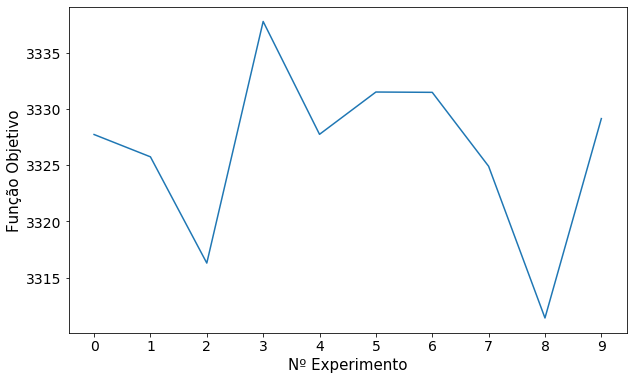

In [148]:
ax = pd.DataFrame(adequacy_criterions_mult).plot(figsize=(10,6),
                                       xticks=range(num_max_experiments),
                                      fontsize=14,
                                      legend=False)

ax.set_xlabel("Nº Experimento", fontsize=15)
ax.set_ylabel("Função Objetivo", fontsize=15)
plt.show()

In [150]:
num_iter_best_exp = best_multiple_matrices.iterations + 1
print("Nº iterações do melhor experimento:", num_iter_best_exp)

np.savetxt(path_results_multiview + 'num_iter_melhor_exp.csv', [num_iter_best_exp], delimiter=',')

Nº iterações do melhor experimento: 6


In [151]:
np.savetxt(path_results_multiview + "funcao_obj.csv", adequacy_criterions_mult, delimiter=",")

### Set-medoids (Protótipos)

In [152]:
best_multiple_matrices.prototypes

array([[ 692],
       [ 661],
       [1717],
       [  36],
       [1831],
       [1722],
       [  25],
       [ 753],
       [  78],
       [1864]])

In [153]:
print("Set-medoids (protótipos):\n")
for num_cluster in range(K):
    print('Q' + str(num_cluster+1) + ":", best_multiple_matrices.prototypes[num_cluster])

Set-medoids (protótipos):

Q1: [692]
Q2: [661]
Q3: [1717]
Q4: [36]
Q5: [1831]
Q6: [1722]
Q7: [25]
Q8: [753]
Q9: [78]
Q10: [1864]


In [154]:
np.savetxt(path_results_multiview + "prototipos.csv", best_multiple_matrices.prototypes, delimiter=",")

### Partição Fuzzy

In [155]:
best_multiple_matrices.fuzzy_partition

array([[0.06037635, 0.05546225, 0.07311459, ..., 0.05376523, 0.2012007 ,
        0.06299311],
       [0.06320974, 0.06118753, 0.07690489, ..., 0.05787425, 0.18235497,
        0.0699425 ],
       [0.0677925 , 0.06350592, 0.08445756, ..., 0.05895369, 0.17672818,
        0.07653252],
       ...,
       [0.10251634, 0.09809593, 0.0810013 , ..., 0.09410151, 0.09630054,
        0.12265326],
       [0.1000335 , 0.09895682, 0.08402019, ..., 0.09365571, 0.09278749,
        0.1317448 ],
       [0.08877798, 0.10203466, 0.08378263, ..., 0.11388018, 0.07933743,
        0.11002313]])

In [179]:
memberships_sums = best_multiple_matrices.fuzzy_partition.sum(axis=1)
memberships_sums

array([1., 1., 1., ..., 1., 1., 1.])

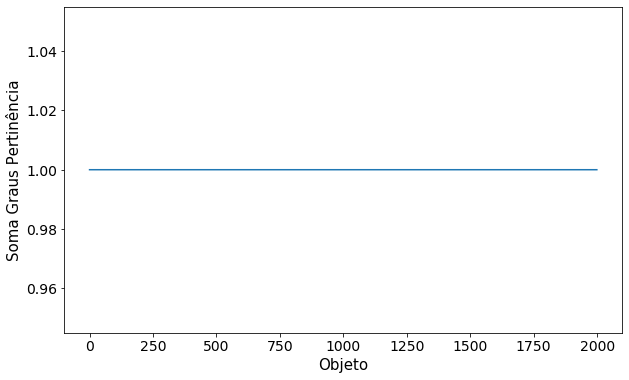

In [195]:
# Os graus de pertinência de cada objeto devem somar 1.
ax = pd.DataFrame(memberships_sums).plot(figsize=(10,6),
                                      fontsize=14,
                                      legend=False)

ax.set_xlabel("Objeto", fontsize=15)
ax.set_ylabel("Soma Graus Pertinência", fontsize=15)
plt.show()

In [205]:
# Os que não somam, é devido a erros numéricos.
memberships_sums.min(), memberships_sums.max()

(0.9999999999999998, 1.0000000000000002)

In [156]:
np.savetxt(path_results_multiview + "particao_fuzzy.csv", best_multiple_matrices.fuzzy_partition, delimiter=",")

### Partição Crisp

In [157]:
best_multiple_matrices.fuzzy_to_crisp()
best_multiple_matrices.crisp_partition

array([8, 8, 8, ..., 4, 9, 4])

In [158]:
print("Lista de Objetos por Grupo:\n")

crisp_clusters_mult = [np.where(best_multiple_matrices.crisp_partition == k)[0] for k in range(K)]

for k in range(K): 
    print('Q' + str(k+1) + ":", crisp_clusters_mult[k], '\n')

Lista de Objetos por Grupo:

Q1: [ 203  205  207  209  217  218  219  221  223  231  232  234  239  241
  245  249  251  253  256  259  262  263  268  270  271  273  277  280
  285  286  289  291  293  294  295  297  298  310  311  314  317  319
  320  323  326  334  339  341  345  346  350  357  363  366  368  377
  378  379  381  382  383  386  388  389  394  396  399  405  451  565
  567  583  600  609  611  615  617  620  621  631  634  637  649  650
  651  657  667  670  671  673  677  682  686  690  692  699  700  705
  711  716  717  720  730  736  740  741  744  769  770  775  784  785
  787  791  795  799  801  803  806  814  816  826  830  831  837  847
  848  872  873  887  899  903  904  930  931  932  962  966  977  984
  986  996  997 1001 1011 1016 1023 1025 1037 1039 1047 1049 1050 1052
 1054 1056 1060 1067 1068 1069 1078 1080 1089 1096 1099 1110 1114 1121
 1122 1128 1132 1133 1135 1143 1146 1151 1153 1175 1185 1189 1191 1194
 1198 1199 1222 1233 1241 1249 1263 1280 128

In [159]:
print("Número de Objetos em cada Grupo Crisp: \n")

num_objects_crisp_mult = [cluster.shape[0] for cluster in crisp_clusters_mult]

for k in range(K):
    
    print('Q' + str(k+1) + ":", num_objects_crisp_mult[k])

Número de Objetos em cada Grupo Crisp: 

Q1: 200
Q2: 168
Q3: 397
Q4: 52
Q5: 479
Q6: 150
Q7: 103
Q8: 151
Q9: 114
Q10: 186


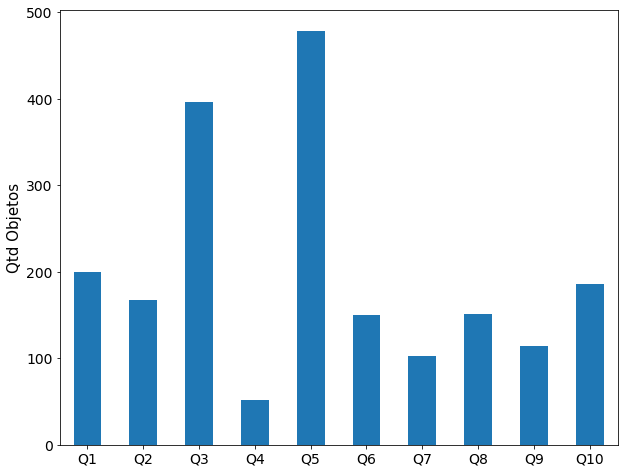

In [160]:
ax = pd.DataFrame(num_objects_crisp_mult).plot.bar(figsize=(10,8),
                                              fontsize=14,
                                              legend=False,
                                              rot=0)
        
ax.set_xticklabels(['Q' + str(k+1) for k in range(K)])
ax.set_ylabel("Qtd Objetos", fontsize=15)
plt.show()

In [161]:
np.savetxt(path_results_multiview + "particao_crisp.csv", best_multiple_matrices.crisp_partition, delimiter=",")

### Pesos das Matrizes

In [162]:
best_multiple_matrices.relevance_weights

array([[0.62546765, 1.20655669, 1.32509621],
       [0.59664723, 1.22740541, 1.36550828],
       [0.60511056, 1.21661274, 1.3583538 ],
       [0.62558544, 1.15381799, 1.3854028 ],
       [0.59709906, 1.16749705, 1.43449097],
       [0.65113622, 1.14566644, 1.34050967],
       [0.6269772 , 1.09731552, 1.45350567],
       [0.62889041, 1.15991183, 1.37088191],
       [0.61996293, 1.11364121, 1.44840156],
       [0.62249977, 1.14849643, 1.39872119]])

In [194]:
weights_prod = best_multiple_matrices.relevance_weights.prod(axis=1)
weights_prod

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

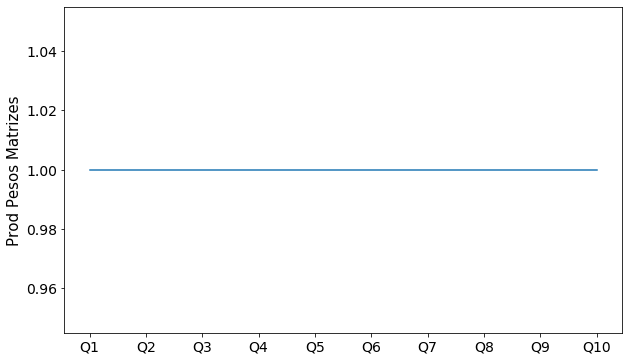

In [202]:
# O produto dos pesos das matrizes para cada cluster deve ser 1.
ax = pd.DataFrame(weights_prod).plot(figsize=(10,6),
                                      fontsize=14,
                                    xticks = range(10),
                                      legend=False)

ax.set_xticklabels(['Q' + str(k+1) for k in range(K)])
ax.set_ylabel("Prod Pesos Matrizes", fontsize=15)
plt.show()

In [206]:
# Os que não resultam em 1, é devido a erros numéricos.
weights_prod.min(), weights_prod.max()

(0.999999999999999, 0.9999999999999994)

In [207]:
cols = ['View'+ str(i+1) for i in range(p)]

pd.DataFrame(best_multiple_matrices.relevance_weights, columns=cols, 
             index = ['Q' + str(k+1) for k in range(K)])

,View1,View2,View3
Q1,0.625468,1.206557,1.325096
Q2,0.596647,1.227405,1.365508
Q3,0.605111,1.216613,1.358354
Q4,0.625585,1.153818,1.385403
Q5,0.597099,1.167497,1.434491
Q6,0.651136,1.145666,1.340510
Q7,0.626977,1.097316,1.453506
Q8,0.628890,1.159912,1.370882
Q9,0.619963,1.113641,1.448402
Q10,0.622500,1.148496,1.398721


In [208]:
np.savetxt(path_results_multiview + "pesos_matrizes.csv", best_multiple_matrices.relevance_weights, delimiter=",")

### Métricas

In [209]:
measures_multiview = []

#### Métricas Internas

Modified Partition Coefficient

In [210]:
mpc = best_multiple_matrices.mod_partition_coeff()
mpc

0.010821174248414

In [211]:
measures_multiview.append(mpc)

Partition Entropy

In [212]:
pe = best_multiple_matrices.partition_entropy()
pe

2.266436381341166

In [213]:
measures_multiview.append(pe)

#### Métricas Externas

In [214]:
best_multiple_matrices.confusion_matrix()

cols =  ['Q' + str(k+1) for k in range(K)] + ['Soma']
indexes = ['P' + str(k+1) for k in range(K)] + ['Soma']

pd.DataFrame(best_multiple_matrices.expand_confusion_matrix, columns=cols, index=indexes)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Soma
P1,0,0,2,29,0,2,73,0,94,0,200
P2,67,31,10,0,47,5,0,4,0,36,200
P3,5,21,17,7,113,23,5,6,1,2,200
P4,44,67,1,0,1,0,0,84,0,3,200
P5,27,5,134,0,3,4,0,14,2,11,200
P6,41,20,17,6,31,4,2,28,3,48,200
P7,15,2,178,1,0,0,0,1,2,1,200
P8,1,21,0,0,158,0,0,13,0,7,200
P9,0,1,36,9,1,112,23,0,12,6,200
P10,0,0,2,0,125,0,0,1,0,72,200


Índice de Rand Corrigido

In [215]:
ar_index = best_multiple_matrices.adjusted_rand_index()
ar_index

0.26617543496019475

In [216]:
measures_multiview.append(ar_index)

F-measure

In [217]:
f1 = best_multiple_matrices.f_measure()
f1

0.4517579077106426

In [218]:
measures_multiview.append(f1)

Erro de Atribuição

In [219]:
error_rate = best_multiple_matrices.classification_error_rate()
error_rate

0.5329999999999999

In [220]:
measures_multiview.append(error_rate)

#### Métricas Sumarizadas

In [221]:
measures_multiview

[0.010821174248414,
 2.266436381341166,
 0.26617543496019475,
 0.4517579077106426,
 0.5329999999999999]

In [222]:
cols = ['Mod Partition Coeff', 'Partition Entropy', 'Indice Rand Corr',
        'F-measure', 'Erro Atribuição']

pd.DataFrame(measures_multiview, index = cols).T

,Mod Partition Coeff,Partition Entropy,Indice Rand Corr,F-measure,Erro Atribuição
0,0.010821,2.266436,0.266175,0.451758,0.533


## Persistir Objeto do Experimento

In [225]:
exp_object_file = open(path_results_multiview + "experiment_object", "wb")

pickle.dump(best_multiple_matrices, exp_object_file)

exp_object_file.close()

# Experimento com a View1 Individualmente

In [ ]:
dissim_matrices = [view1_dissim_matrix]
p = len(dissim_matrices)

G = Lambda = U = None

best_view1, adequacy_criterions_view1 = run_experiments()

# Experimento com a View2 Individualmente

In [ ]:
dissim_matrices = [view2_dissim_matrix]
p = len(dissim_matrices)

G = Lambda = U = None

best_view2, adequacy_criterions_view2 = run_experiments()

# Experimento com a View3 Individualmente

In [ ]:
dissim_matrices = [view3_dissim_matrix]
p = len(dissim_matrices)

G = Lambda = U = None

best_view3, adequacy_criterions_view3 = run_experiments()